In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import librosa

In [2]:
#calculate the mean and std (see in the CNN notebook)
mean = -50.217636
std = 16.921597

In [3]:
class AudioDataset(Dataset):
    def __init__(self, label_dir, song_dir, is_train):
        self.labels = self.read_labels(label_dir)
        self.song_dir = song_dir
        self.is_train = is_train

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        mp3_path = self.song_dir + f"/{idx}.mp3"
        y, sr = librosa.load(mp3_path, sr=22050)

        if self.is_train and random.random() < 0.3:
            y_flipped = np.flip(y)
        else:
            y_flipped = y
        
        mel_spec = librosa.feature.melspectrogram(y=y_flipped, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_normalized = (mel_spec_db - (-50.217636)) / (16.921597)
        mel_tensor = torch.tensor(mel_spec_normalized).unsqueeze(0)
        
        if self.is_train and random.random() < 0.3:
            mel_tensor=self.time_mask(mel_tensor)

        if self.is_train and random.random() < 0.3:
            mel_tensor = self.freq_mask(mel_tensor)

        return mel_tensor, label

    def freq_mask(self, spec, F=5, num_masks=1):
        test = spec.clone()
        num_mel_channels = test.shape[1]
        for i in range(0, num_masks):        
            freq = random.randrange(0, F)
            zero = random.randrange(0, num_mel_channels - freq)
            if (zero == zero + freq): return test
            mask_end = random.randrange(zero, zero + freq) 
            test[0][zero:mask_end] = test.mean()
        return test

    def time_mask(self, spec, time=10, num_masks=1):
        test = spec.clone()
        length = test.shape[2]
        for i in range(0, num_masks):
            t = random.randrange(0, time)
            zero = random.randrange(0, length - t)
            if (zero == zero + t): return test
            mask_end = random.randrange(zero, zero + t)
            test[0][:,zero:mask_end] = test.mean()
        return test

    def read_labels(self, label_file):
        with open(label_file, 'r') as f:
            labels = f.readlines()
        return [int(label.strip()) for label in labels]

# Create train dataset
song_dir = "train_aug"
label_dir = "train_label.txt"
train_dataset = AudioDataset(label_dir, song_dir, is_train=True)

# Calculate sizes for train and validation sets
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

# Split train set into train and validation
np.random.seed(42)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

# Create data loaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [4]:
for i, batch in enumerate(train_loader):
    feature_batch_torch, label_batch_torch = batch
    print(feature_batch_torch.shape)
    print(label_batch_torch)
    if i>1:
        break

torch.Size([16, 1, 128, 130])
tensor([1, 3, 3, 3, 1, 3, 1, 2, 1, 2, 1, 3, 0, 3, 1, 3])
torch.Size([16, 1, 128, 130])
tensor([3, 1, 3, 0, 2, 3, 3, 0, 1, 2, 1, 3, 3, 3, 3, 3])
torch.Size([16, 1, 128, 130])
tensor([3, 3, 0, 1, 3, 1, 1, 1, 0, 1, 3, 1, 3, 2, 3, 1])


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 4):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1), #7，2，3
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [6]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        valid_loss = running_loss/len(dataloader.dataset)
    accuracy = correct_predictions / total_predictions
    return accuracy, valid_loss

def predict_audio_test(test_dir, device, model, epoch):
    ids = []
    predictions = []

    for filename in os.listdir(test_dir):
        song_id = int(filename[:-4])
        song_path = os.path.join(test_dir, filename)
        y, sr = librosa.load(song_path)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_normalized = (mel_spec_db - (-50.217636)) / (16.921597)
        mel_tensor = torch.tensor(mel_spec_normalized).unsqueeze(0)
        with torch.no_grad():
            input = mel_tensor.to(device)
            output = model(input.unsqueeze(0))
            _, predicted = torch.max(output, 1)

        ids.append(song_id)
        predictions.append(predicted.item())

    submission_df = pd.DataFrame({'id': ids, 'category': predictions})
    submission_df.to_csv(f'test_predictions_{epoch}.csv', index=False)
    # torch.save(model,f"resnetmodels/{epoch}.pth")


In [7]:
def plot(train_losses,valid_losses,valid_accuracy,num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.plot(range(1, num_epochs + 1), valid_accuracy, label='Validation Acc')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [8]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam   

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)   

def calculate_class_weights(dataset):
    class_counts = np.bincount(dataset)
    class_weights = 1. / class_counts
    normalized_weights = class_weights / class_weights.sum()
    return torch.FloatTensor(normalized_weights)

In [9]:
def train(model, train_loader, valid_loader, optimizer, criterion, device, scheduler,num_epochs=5):
    model.train()
    valid_losses=[]
    train_losses=[]
    valid_acc=[]
    for epoch in range(num_epochs):

        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() # clear gradient
            
            #mix-up
            inputs_mixed, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=0.4, use_cuda=True)
            outputs = model(inputs_mixed)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            loss.backward() # compute gradient
            
            optimizer.step() # run optimizer (perform model update)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")
        valid_accuracy, valid_loss = evaluate_model(model, valid_loader, criterion, device)
        scheduler.step(valid_accuracy)
        lr = optimizer.state_dict()['param_groups'][0]['lr']
        print(f"lr:{lr} valid_loss:{valid_loss} valid_acc:{valid_accuracy}")
        valid_losses.append(valid_loss)
        train_losses.append(epoch_loss)
        valid_acc.append(valid_accuracy)
        
        test_dir = 'test_aug'
        predict_audio_test(test_dir, device, model, epoch+1)
        # torch.save(model.state_dict(),f"resnetmodels/{epoch+1}.pth")
    plot(train_losses,valid_losses,valid_acc,num_epochs)


Epoch 1/40, Train Loss: 1.0297
lr:0.005 valid_loss:1.538451352973662 valid_acc:0.5386879730866274
Epoch 2/40, Train Loss: 1.0058
lr:0.005 valid_loss:0.6867297090734124 valid_acc:0.6799831791421362
Epoch 3/40, Train Loss: 0.8685
lr:0.005 valid_loss:0.6800653051187051 valid_acc:0.6728343145500421
Epoch 4/40, Train Loss: 0.8378
lr:0.005 valid_loss:0.65951472325321 valid_acc:0.6766190075693861
Epoch 5/40, Train Loss: 0.7965
lr:0.005 valid_loss:0.6402006174357023 valid_acc:0.7275021026072329
Epoch 6/40, Train Loss: 0.7598
lr:0.005 valid_loss:0.5668462323380479 valid_acc:0.7489486963835156
Epoch 7/40, Train Loss: 0.7482
lr:0.005 valid_loss:0.5000297880854498 valid_acc:0.7741799831791422
Epoch 8/40, Train Loss: 0.7178
lr:0.005 valid_loss:0.47252433063404414 valid_acc:0.7863751051303617
Epoch 9/40, Train Loss: 0.6681
lr:0.005 valid_loss:0.49117160354771466 valid_acc:0.787636669470143
Epoch 10/40, Train Loss: 0.6877
lr:0.005 valid_loss:0.45887500293321026 valid_acc:0.8002523128679563
Epoch 11/4

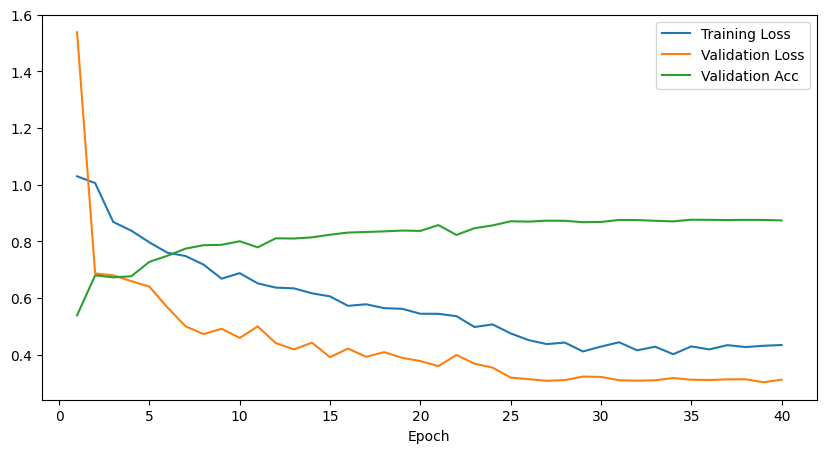

In [10]:
#train
num_classes = 4
num_epochs = 40
batch_size = 16
init_lr = 0.005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [3,4,6,3], num_classes).to(device)

# criterion with labels weights
train_labels = [label for _, label in train_dataset]
class_weights = calculate_class_weights(train_labels)
class_weights_tensor = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, weight_decay = 0.0001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)
train(model, train_loader, valid_loader, optimizer, criterion, device, scheduler, num_epochs)